In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-04-29 16:09:53.453797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745942993.639632      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745942993.701499      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1745943205.913550      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


I0000 00:00:1745943217.816663     101 service.cc:148] XLA service 0x7e57f010a210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745943217.817388     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745943218.289477     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/110 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.1719 - loss: 1.8849  

I0000 00:00:1745943227.618533     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


110/110 ━━━━━━━━━━━━━━━━━━━━ 35s 193ms/step - accuracy: 0.2084 - loss: 1.8546 - val_accuracy: 0.3400 - val_loss: 1.6224
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.2923 - loss: 1.6606 - val_accuracy: 0.5707 - val_loss: 1.4196
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.4598 - loss: 1.4736 - val_accuracy: 0.7960 - val_loss: 1.1546
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.6228 - loss: 1.2221 - val_accuracy: 0.8667 - val_loss: 0.8529
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.7605 - loss: 0.9487 - val_accuracy: 0.9213 - val_loss: 0.5973
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.8387 - loss: 0.6851 - val_accuracy: 0.9480 - val_loss: 0.4212
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.8852 - loss: 0.5179 - val_accuracy: 0.9573 - val_loss: 0.3054
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.9151 - loss: 0.3948 - val_accura

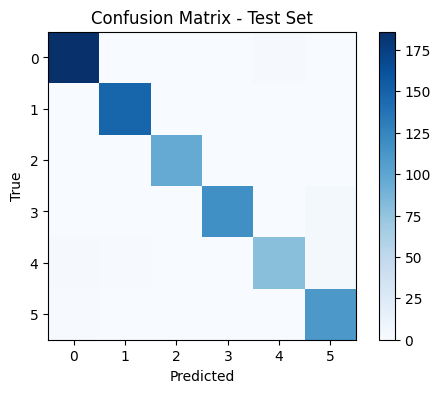

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import pyarrow.parquet as pq
from PIL import Image

# Paths
data_csv = "/kaggle/input/hms-harmful-brain-activity-classification/train.csv"
parquet_dir = "/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms"

# Load metadata
df = pd.read_csv(data_csv)
existing_files = set(os.listdir(parquet_dir))
df = df[df["spectrogram_id"].apply(lambda x: f"{x}.parquet" in existing_files)]
df = df.head(5000)

if df.empty:
    raise ValueError("No matching .parquet files found.")

# Encode labels
y = df["expert_consensus"].dropna()
df = df.loc[y.index]
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Metadata features
X_meta = df[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].values
scaler = StandardScaler()
X_meta = scaler.fit_transform(X_meta)

# Helper to load and preprocess spectrogram image
def load_spectrogram_as_image(spectrogram_id, size=(224, 224)):
    file_path = os.path.join(parquet_dir, f"{spectrogram_id}.parquet")
    table = pq.read_table(file_path)
    data = table.to_pandas().values.T.astype(np.float32)
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
    data = np.log1p(np.clip(data, a_min=1e-6, a_max=None))
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
    data = (data - np.min(data)) / (np.max(data) - np.min(data) + 1e-8)
    img = Image.fromarray(np.uint8(data * 255)).convert("RGB").resize(size)
    return np.array(img)

# Load all images
X_images = np.stack([load_spectrogram_as_image(sid) for sid in df["spectrogram_id"]])
X_images = X_images / 255.0  # Normalize

# Train-val-test split
X_img_train, X_img_temp, X_meta_train, X_meta_temp, y_train, y_temp = train_test_split(
    X_images, X_meta, y_categorical, test_size=0.3, random_state=42, stratify=y_categorical)
X_img_val, X_img_test, X_meta_val, X_meta_test, y_val, y_test = train_test_split(
    X_img_temp, X_meta_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# VGG16 image branch
image_input = keras.Input(shape=(224, 224, 3), name="image_input")
base_vgg16 = keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_vgg16.trainable = False  # Freeze base
x = base_vgg16(image_input)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
image_features = layers.Dense(128, activation='relu')(x)

# Metadata branch
meta_input = keras.Input(shape=(X_meta.shape[1],), name="meta_input")
y_meta = layers.Dense(64, activation='relu')(meta_input)
y_meta = layers.Dropout(0.3)(y_meta)
meta_features = layers.Dense(32, activation='relu')(y_meta)

# Combine both
combined = layers.concatenate([image_features, meta_features])
z = layers.Dense(128, activation='relu')(combined)
z = layers.Dropout(0.5)(z)
output = layers.Dense(y_categorical.shape[1], activation='softmax')(z)

# Final model
model = keras.Model(inputs=[image_input, meta_input], outputs=output)
model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("best_vgg16_model.keras", monitor='val_loss', save_best_only=True)
]

# Train
history = model.fit(
    x=[X_img_train, X_meta_train],
    y=y_train,
    validation_data=([X_img_val, X_meta_val], y_val),
    epochs=10,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Evaluate
y_pred = model.predict([X_img_test, X_meta_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("Test Accuracy:", accuracy_score(y_true_classes, y_pred_classes))
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
plt.figure(figsize=(6, 4))
plt.imshow(confusion_matrix(y_true_classes, y_pred_classes), cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()